# 最速降线

最速降线是经典的变分法示例，我们简单回顾一下这个问题：

> 在所有连接$M_1$和$M_2$两点的曲线中，求一曲线，使当质点在重力影响之下，没有初速地沿此曲线从M_1运动到达M_2所需时间最短。

根据能量守恒，可以简单的得到

$$
\frac{1}{2}v^2=gy
$$

或 

$$
v=\sqrt{2gy}
$$

建立坐标系令
$$
\left\{
\begin{aligned}
M_1&=(0, 0) \\
M_2&=(x_2, y_2)
\end{aligned}
\right.
$$

可以将最速降线表达为使积分方程

$$
T=\frac{1}{\sqrt{2g}}\int_{0}^{x_2}\frac{\sqrt{1+y'^2}}{\sqrt{y}}\,dx
$$

达到最小值的函数y。


## 最优问题

现在我们将这个积分问题转换为最优化问题

$$
\begin{aligned}
\min_{x\in\left[x_1, x_2\right]}&&\frac{1}{\sqrt{2g}}\int_{0}^{x_2}\frac{\sqrt{1+y'^2}}{\sqrt{y}}\,dx\\
subject\,to&& \left\{\begin{aligned}y(0)&=0\\y(x_2)&=y_2\end{aligned}\right.
\end{aligned}
$$

建立python casadi 代码进行求解和仿真。

## 实现

第一步，我们还是导入环境

In [1]:
import casadi as ca
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import time

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

设定方程和求解器，因为变分法是求解积分方程的最优化过程，所以对于 CasADi 是现成的。

In [2]:
# 参数
g = 9.81
x_start = 0.0
x_end = 20.0
y_end = 10.0
N = 128

aixs = [x*x_end/N for x in range(N)]

# 离散化
x = np.linspace(x_start, x_end, N + 1)
h = x[1] - x[0]

# CasADi 变量
y = ca.MX.sym("y", N + 1)

# 构建目标函数
obj = 0
for i in range(N):
    dy = y[i+1] - y[i]
    dx = x[i+1] - x[i]
    slope = dy / dx
    integrand = (1/ca.sqrt(2*g))*ca.sqrt(1 + slope**2) / ca.sqrt(y[i] + 1e-6)
    obj += integrand * dx

# 构建约束 
constraints = []
constraints += [y[0]]
constraints += [y[-1] - y_end]

# 构建优化器
nlp = {"x": y, "f": obj, "g": ca.vertcat(*constraints)}
solver = ca.nlpsol("solver", "ipopt", nlp, {
    "ipopt.print_level": 0,
    "print_time": False
})

# 初始猜测 
y_init = np.linspace(0, y_end, N + 1)

我们定义一个计速函数，简单粗暴的根据曲线路径累计计时。

In [3]:
def calculate_time(x_vals, y_vals):
    """计算给定路径的下落时间"""
    total_time = 0.0
    for i in range(len(x_vals) - 1):
        dx = x_vals[i+1] - x_vals[i]
        dy = y_vals[i+1] - y_vals[i]
        
        # 计算当前段的斜率
        slope = dy / dx
        
        # 计算弧长微元
        ds = np.sqrt(1 + slope**2) * dx
        
        # 使用中点处的y值计算速度
        y_mid = (y_vals[i] + y_vals[i+1]) / 2
        
        # 避免除以零
        if y_mid < 1e-6:
            v = np.sqrt(2 * g * 1e-6)
        else:
            v = np.sqrt(2 * g * y_mid)
        
        # 计算当前段的时间
        dt = ds / v
        total_time += dt
    
    return total_time

因为最速降线有解析解，可以根据公式直接算出结果，不过这个结果我就不画上去了，因为跟数值解实在没有什么误差，视觉上看不到结果。有兴趣的朋友可以自己画上去试试。

这里我还给出了直线和抛物线的轨迹和用时。


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



CasADi - 2025-06-01 22:04:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
/var/folders/tm/s1d21dpj3_3bx9blf642czlh0000gn/T/ipykernel_75157/532669784.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  a = y_end / (1 - np.cos(theta_end))
/var/folders/tm/s1d21dpj3_3bx9blf642czlh0000gn/T/ipykernel_75157/532669784.py:14: RuntimeWarning: invalid value encountered in multiply
  x_cycloid = a * (theta_vals - np.sin(theta_vals))
/var/folders/tm/s1d21dpj3_3bx9blf642czlh0000gn/T/ipykernel_75157/532669784.py:15: RuntimeWarning: invalid value encountered in multiply
  y_cycloid = a * (1 - np.cos(theta_vals))


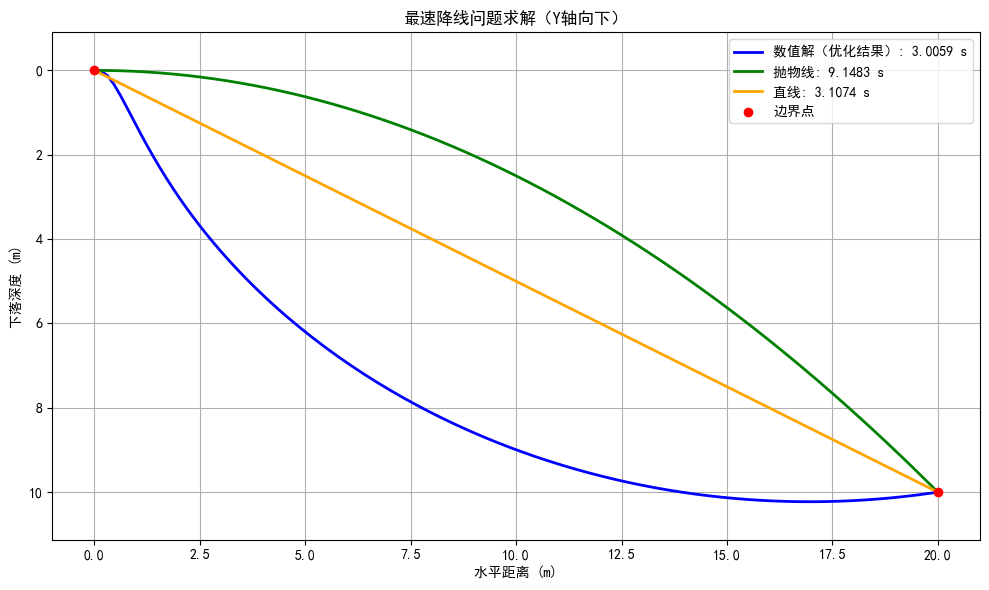

摆线参数: a = inf, θ_end = 0.0000 rad

各路径下落时间:
数值解（优化结果）: 3.005935 秒
抛物线路径: 9.148262 秒
直线路径: 3.107404 秒


In [4]:
# 求解
sol = solver(x0=y_init, lbg=0, ubg=0)
y_opt = sol["x"].full().flatten()

# 计算理论解（摆线
def equations(p):
    theta = p[0]
    return [theta - np.sin(theta) - 2*(1 - np.cos(theta))]

theta_end = fsolve(equations, [2*np.pi])[0]
a = y_end / (1 - np.cos(theta_end))

theta_vals = np.linspace(0, theta_end, N + 1)  # 增加点数以提高精度
x_cycloid = a * (theta_vals - np.sin(theta_vals))
y_cycloid = a * (1 - np.cos(theta_vals))

# 计算各曲线的用时
time_opt = calculate_time(x, y_opt)
time_cycloid = calculate_time(x_cycloid, y_cycloid)

# 抛物线路径：y = 0.025 * x^2
y_parabola = 0.025 * x**2
time_parabola = calculate_time(x, y_parabola)

# 直线路径：y = 0.5 * x
y_line = 0.5 * x
time_line = calculate_time(x, y_line)

# === 修改后的绘图（Y轴向下） ===
plt.figure(figsize=(10, 6))

# 绘制所有曲线（保持原始数据不变）
plt.plot(x, y_opt, 'b-', linewidth=2, label=f"数值解（优化结果）: {time_opt:.4f} s")
plt.plot(x, y_parabola, color='green', linewidth=2, label=f"抛物线: {time_parabola:.4f} s")
plt.plot(x, y_line, color='orange', linewidth=2, label=f"直线: {time_line:.4f} s")
plt.scatter([0, x_end], [0, y_end], color='red', zorder=5, label="边界点")

# 关键修改：反转Y轴方向
plt.gca().invert_yaxis()  # 使Y轴向下为正方向

# 调整标签和标题
plt.xlabel("水平距离 (m)")
plt.ylabel("下落深度 (m)")
plt.title("最速降线问题求解（Y轴向下）")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

# === 打印理论解参数和时间 ===
print(f"摆线参数: a = {a:.4f}, θ_end = {theta_end:.4f} rad")
print("\n各路径下落时间:")
print(f"数值解（优化结果）: {time_opt:.6f} 秒")
print(f"抛物线路径: {time_parabola:.6f} 秒")
print(f"直线路径: {time_line:.6f} 秒")